In [1]:
%matplotlib inline

import os
import time
import math
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from torch.cuda.amp import GradScaler, autocast
from PIL import Image

import torch
from torch.nn import functional as F
from torch.autograd import Variable

##############################
from models import unet
from datasets import datasets

from utils import manager as mgr
from utils import metrics
from utils import losses
from utils import log
from utils import img_utils
##############################

nr_classes = 4
nr_channels = 7
exp_name = 'unet_std_001'
DEVICE = "cuda:0"
WEIGHTS_PATH = 'weights/' + exp_name + '/'

# set device
#device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
device = "cuda:0"
device_nr = int(0)
#device = "cpu"
print(device)

batch_size = 64
split={'train':0.7, 'val':0.1, 'test':0.2}
num_workers=4
pin_memory=True

LR = 0.01
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 10

cuda:0


In [2]:
torch.cuda.empty_cache()

# backbone
if exp_name == 'unet_std_001':
    WEIGHTS_FILE = 'weights-15-0.156-0.871.pth'

In [3]:
## Creating the dataset
path_dataset = "/media/philipp/DATA/dataset/dataset_256_df_177.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_512_df_177.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_mask_512_df_177.h5"
dataset = datasets.ForestDataset(path_dataset, ground_truth='ground_truth_std')

if dataset[0][0].shape[1] == 256:
    chunk_size = 1000
else:
    chunk_size = 0

# shuffle and split
train_sampler, val_sampler, test_sampler = dataset.get_sampler(split=split, \
                shuffle_dataset=True, random_seed=399, chunk_size=chunk_size, fold=0)

# dataloader
train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
val_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=val_sampler, num_workers=num_workers, pin_memory=pin_memory)
test_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=test_sampler, num_workers=num_workers, pin_memory=pin_memory)
print(len(dataset))
print(len(train_sampler.indices))
print(len(val_sampler.indices))
print(len(test_sampler.indices))

42716
29908
4268
8540


In [4]:
#############
#   train
#############
def train(model, trn_loader, optimizer, criterion, epoch):
    
    model.train()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}

    for idx, data in enumerate(trn_loader):
        x = Variable(data[0].to(device))
        y = Variable(data[1].to(device))
        step += 1
        
        # forward pass
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()

        # calculate predictions
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*trn_loader.batch_size
        
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
    
    # calculate metrics for the epoch      
    for i in metric:
        metric[i] /= len(train_sampler.indices)
                    
    return metric

#############
#   test
#############
def test(model, test_loader, criterion, epoch=1):
    
    model.eval()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}
    
    for data, target in test_loader:
        x = Variable(data.to(device))
        y = Variable(target.to(device))
        step += 1
        
        # forward pass
        with torch.no_grad():
            output = model(x)
            loss = criterion(output, y)
            #test_loss += criterion(output, y).data.item()
            
        # calculate predictions    
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*test_loader.batch_size
            
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
        
    # calculate metrics for the epoch      
    for i in metric:
        metric[i] /= len(val_sampler.indices)
                    
    return metric

In [5]:
#############
#   test 
#############
def test(model, test_loader, criterion, epoch=1):
    
    model.eval()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}
    cm = torch.zeros((nr_classes, nr_classes))
    
    for data, target in test_loader:
        x = Variable(data.to(device))
        y = Variable(target.to(device))
        step += 1
        
        # forward pass
        with torch.no_grad():
            output = model(x)
            loss = criterion(output, y)
            #test_loss += criterion(output, y).data.item()
            
        # calculate predictions    
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice, cm_b = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device, cm=True)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*test_loader.batch_size
        cm += cm_b
            
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
        
    # calculate metrics for the epoch
    for i in metric:
        metric[i] /= len(val_sampler.indices)
                    
    return metric, cm

In [6]:
from pathlib import Path
path_to_weights = '/home/philipp/Code/work/new_unet/'+WEIGHTS_PATH+WEIGHTS_FILE
path = Path(path_to_weights)
path.is_file()

True

In [7]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 64, 3, 1)
        self.conv2 = self.contract_block(64, 128, 3, 1)
        self.conv3 = self.contract_block(128, 256, 3, 1)
        self.conv4 = self.contract_block(256, 512, 3, 1)
        
        self.upconv4 = self.expand_block(512, 256, 3, 1)
        self.upconv3 = self.expand_block(256*2, 128, 3, 1)
        self.upconv2 = self.expand_block(128*2, 64, 3, 1)
        self.upconv1 = self.expand_block(64*2, out_channels, 3, 1)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        
        out = self.softmax(upconv1)

        return out

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [8]:
# Network definition
model = UNET(in_channels=nr_channels, out_channels=nr_classes)
try:
    map_location = {'cuda:1':'cuda:0'}
    start_epoch = mgr.load_weights(model, '/home/philipp/Code/work/new_unet/' + \
                                   WEIGHTS_PATH + WEIGHTS_FILE, map_location)
    print("weights loaded")
except:
    print("no weights found")
torch.cuda.set_device(device=device_nr)
model.cuda()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = losses.Dice_Loss()
#criterion = nn.CrossEntropyLoss()


loading weights '/home/philipp/Code/work/new_unet/weights/unet_std_001/weights-15-0.156-0.871.pth'
loaded weights (lastEpoch 15, loss 0.15620845556259155, error 0.8707709312438965)
weights loaded


In [9]:
model

UNET(
  (conv1): Sequential(
    (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256,

In [9]:
def calc_mertics(cm_test, labels):
    labels_m = labels.copy()
    labels_m.append('mean')
    
    true_pos = np.diag(cm_test) 
    precision = true_pos / np.sum(cm_test, axis=0)
    recall = true_pos / np.sum(cm_test, axis=1)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    cm_test_plus = np.zeros((4,cm_test.shape[0]+1))
    cm_test_plus[0,:-1] = precision
    cm_test_plus[1,:-1] = recall
    cm_test_plus[3,:-1] = F1
    
    cm_test_plus[0,-1:] = np.mean(precision)
    cm_test_plus[1,-1:] = np.mean(recall)
    cm_test_plus[3,-1:] = np.mean(F1)

    # Acc all
    acc_all = true_pos.sum()/cm_test.sum()

    # Acc mean
    acc_mean = np.mean(true_pos/cm_test.sum(axis=1))

    # IoU
    false_neg = np.sum(cm_test, axis=0)-true_pos
    false_pos = np.sum(cm_test, axis=1)-true_pos
    iou = true_pos/(true_pos+false_pos+false_neg)
    miou = np.mean(true_pos/(true_pos+false_pos+false_neg))
    
    cm_test_plus[2,:-1] = iou
    cm_test_plus[2,-1:] = miou

    # Dice
    dice = np.mean(F1)
    
    # create dataframes
    df_test = pd.DataFrame(cm_test/10**6, index=labels, columns=labels)
    df_test = df_test.round(1)#.astype(int)
    
    df_test_plus = pd.DataFrame(cm_test_plus, index=['precision [%]', 'recall [%]', 'IoU [%]', 'F1 [%]'], columns=labels_m)
    df_test_plus = (df_test_plus*100).round(2)
    
    df_test_metrics = pd.DataFrame([[acc_all, acc_mean, miou, dice]], \
                       columns=['Acc all', 'Acc mean', 'IoU/Jacc', 'Dice/F1'])
    df_test_metrics = (df_test_metrics*100).round(2)
    
    return df_test, df_test_plus, df_test_metrics

In [10]:
def calc_mertics_void(cm_test, labels):
    labels_m = labels.copy()
    labels_m.append('mean')
    
    true = np.diag(cm_test) 
    precision = true / np.sum(cm_test, axis=0)
    recall = true / np.sum(cm_test, axis=1)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    cm_test_plus = np.zeros((4,cm_test.shape[0]+1))
    cm_test_plus[0,:-1] = precision
    cm_test_plus[1,:-1] = recall
    cm_test_plus[2,:-1] = F1
    
    cm_test_plus[0,-1:] = np.mean(precision[1:])
    cm_test_plus[1,-1:] = np.mean(recall[1:])
    cm_test_plus[2,-1:] = np.mean(F1[1:])

    # Acc all
    acc_all = true[1:].sum()/cm_test[1:].sum()

    # Acc mean
    acc_mean = np.mean(true[1:]/cm_test[1:,1:].sum(axis=1))

    # IoU
    false_neg = np.sum(cm_test, axis=0)-true
    false_pos = np.sum(cm_test, axis=1)-true
    iou = true/(true+false_pos+false_neg)
    miou = np.mean(true[1:]/(true[1:]+false_pos[1:]+false_neg[1:]))
    
    cm_test_plus[3,:-1] = iou
    cm_test_plus[3,-1:] = miou

    # Dice
    dice = np.mean(F1[1:])
    
    # create dataframes
    df_test = pd.DataFrame(cm_test/10**6, index=labels, columns=labels)
    df_test = df_test.round(1)#.astype(int)
    
    df_test_plus = pd.DataFrame(cm_test_plus, index=['precision [%]', 'recall [%]', 'F1 [%]', 'IoU [%]'], columns=labels_m)
    df_test_plus = df_test_plus.round(4)
    
    df_test_metrics = pd.DataFrame([[acc_all, np.mean(precision[1:]), np.mean(recall[1:]), miou, dice]], \
                       columns=['Acc all', 'precision', 'recall', 'IoU/Jacc', 'Dice/F1'])
    df_test_metrics = df_test_metrics.round(4)
    
    return df_test, df_test_plus, df_test_metrics

In [11]:
metric, cm = test(model, val_dl, criterion, epoch=1)

/home/philipp/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
metric

{'loss': tensor(0.1589, device='cuda:0'),
 'acc_all': tensor(0.8709),
 'acc_mean': tensor(0.8324),
 'jacc': tensor(0.7481),
 'dice': tensor(0.8459)}

In [15]:
cmn, score, metric = calc_mertics_void(cm.numpy(), ['void', 'thinning', 'no_thinning', 'other'])

In [16]:
cmn

void  thinning  no_thinning  other
void         21.4       0.0          0.6    0.1
thinning      0.0      47.9         11.9    0.3
no_thinning   0.0      16.7        162.2    1.8
other         0.0       0.5          5.4   10.9

In [17]:
score

void  thinning  no_thinning   other    mean
precision [%]  0.9996    0.7359       0.9005  0.8354  0.8239
recall [%]     0.9711    0.7965       0.8977  0.6490  0.7811
F1 [%]         0.9852    0.7650       0.8991  0.7305  0.7982
IoU [%]        0.9708    0.6194       0.8167  0.5754  0.6705

In [18]:
metric

Acc all  precision  recall  IoU/Jacc  Dice/F1
0   0.8578     0.8239  0.7811    0.6705   0.7982

In [ ]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

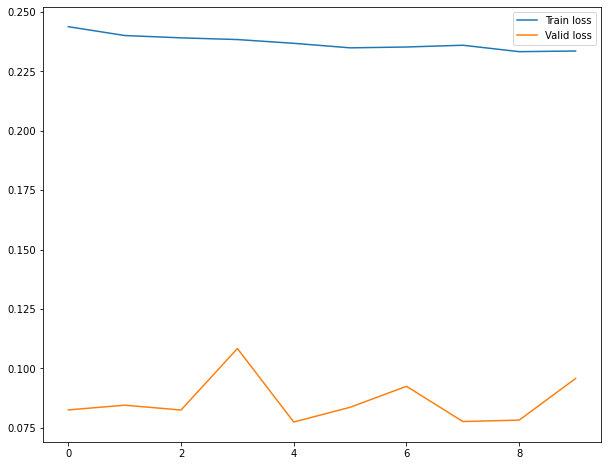

In [18]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

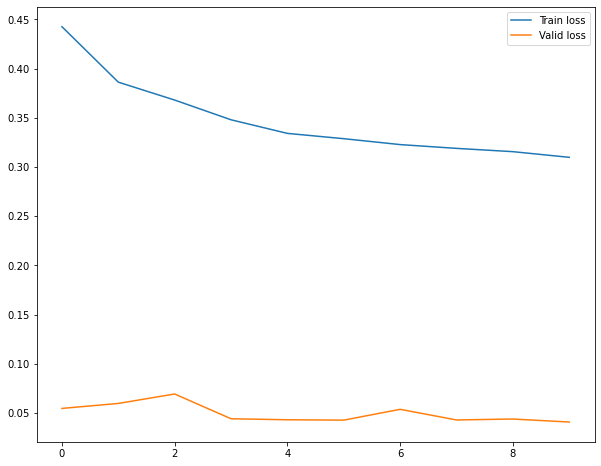

In [18]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

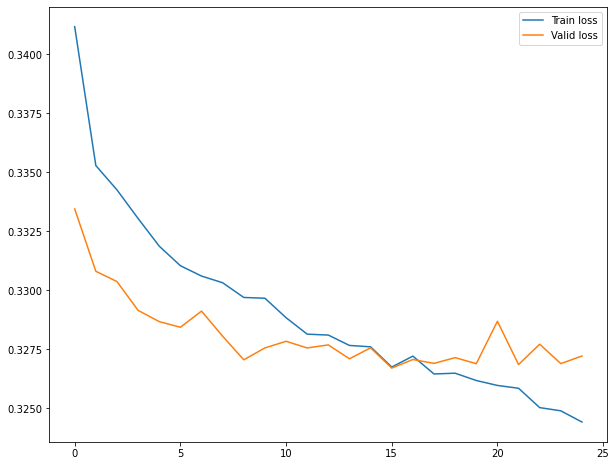

In [37]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [18]:
# predict

In [ ]:
test(model, test_dl, criterion, epoch=1)

In [46]:
import numpy as np
import matplotlib.pyplot as plt

Void = [0,0,0] # gray
Grass = [245,230,15] # yellow
Decidous = [225,27,27] # red
Conifers = [60,200,60] # green
No_Forest = [30,90,215] # blue

DSET_MEAN = [0.41189489566336, 0.4251328133025, 0.4326707089857]
DSET_STD = [0.27413549931506, 0.28506257482912, 0.28284674400252]

label_colours = np.array([Void, Grass, Decidous, Conifers, No_Forest])


def view_annotated(tensor, plot=True):
    temp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,5):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    #mean = np.array(DSET_MEAN)
    #std = np.array(DSET_STD)
    #inp = data.stds_wien * inp + data.means_wien
    return inp

def view_image(tensor):
    inp = decode_image(tensor)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

In [47]:
def view_sample_predictions(model, loader, n):
    inputs, targets = next(iter(loader))
    data = Variable(inputs.cuda())
    label = Variable(targets.cuda())
    with torch.no_grad():
        output = model(data)
    pred = get_predictions(output)
    batch_size = inputs.size(0)
    for i in range(min(n, batch_size)):
        #img_utils.view_image(inputs[i])
        #img_utils.view_annotated(targets[i])
        #img_utils.view_annotated(pred[i])
        view_image(inputs[i,:3])
        view_annotated(targets[i])
        view_annotated(pred[i])

In [48]:
data.means_mariazell

array([ 52.578648,  63.173195,  59.55805 , 101.360756], dtype=float32)

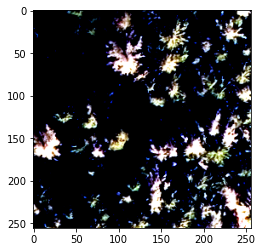

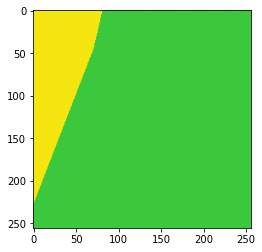

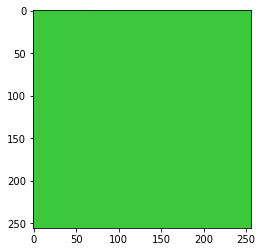

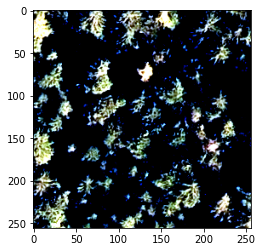

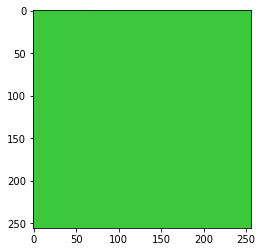

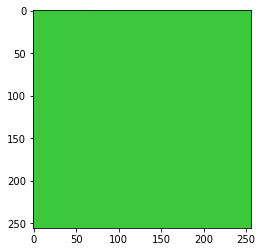

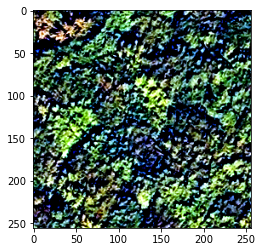

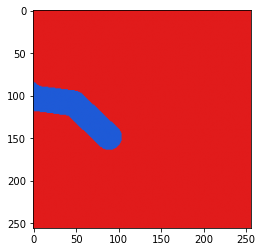

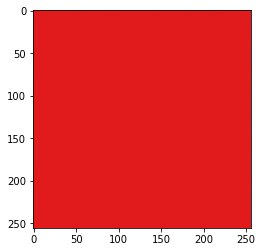

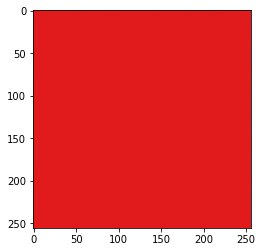

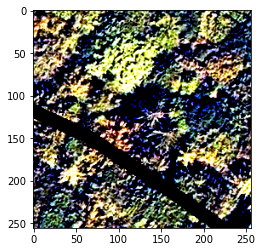

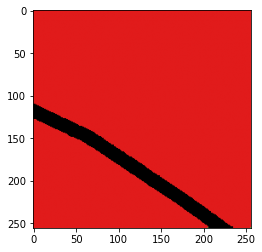

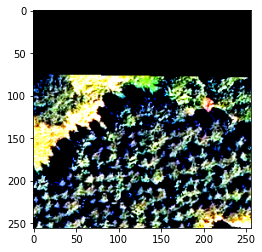

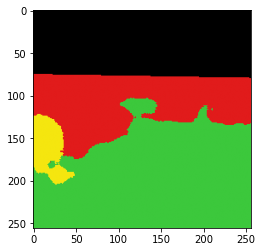

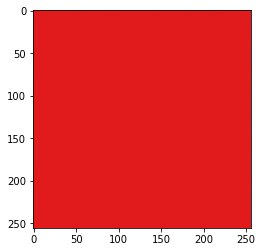

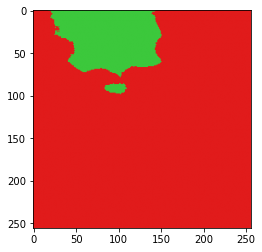

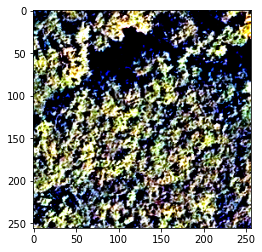

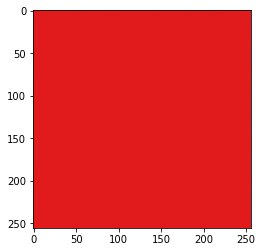

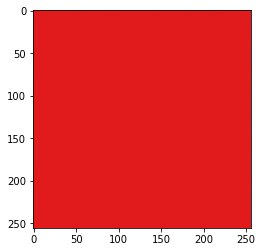

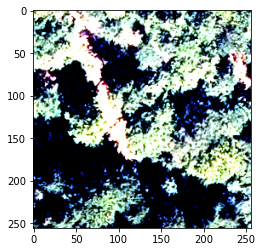

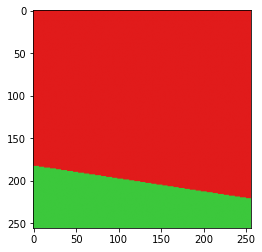

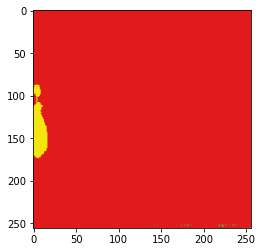

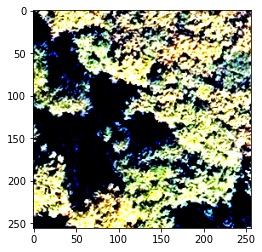

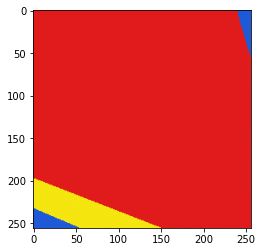

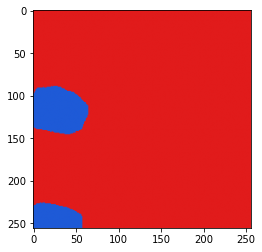

In [49]:
view_sample_predictions(model, valid_dl, n=10)

In [ ]:
view_sample_predictions(model, test_dl, n=10)

In [21]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [22]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.to(device))

predb.shape

TypeError: 'module' object is not callable

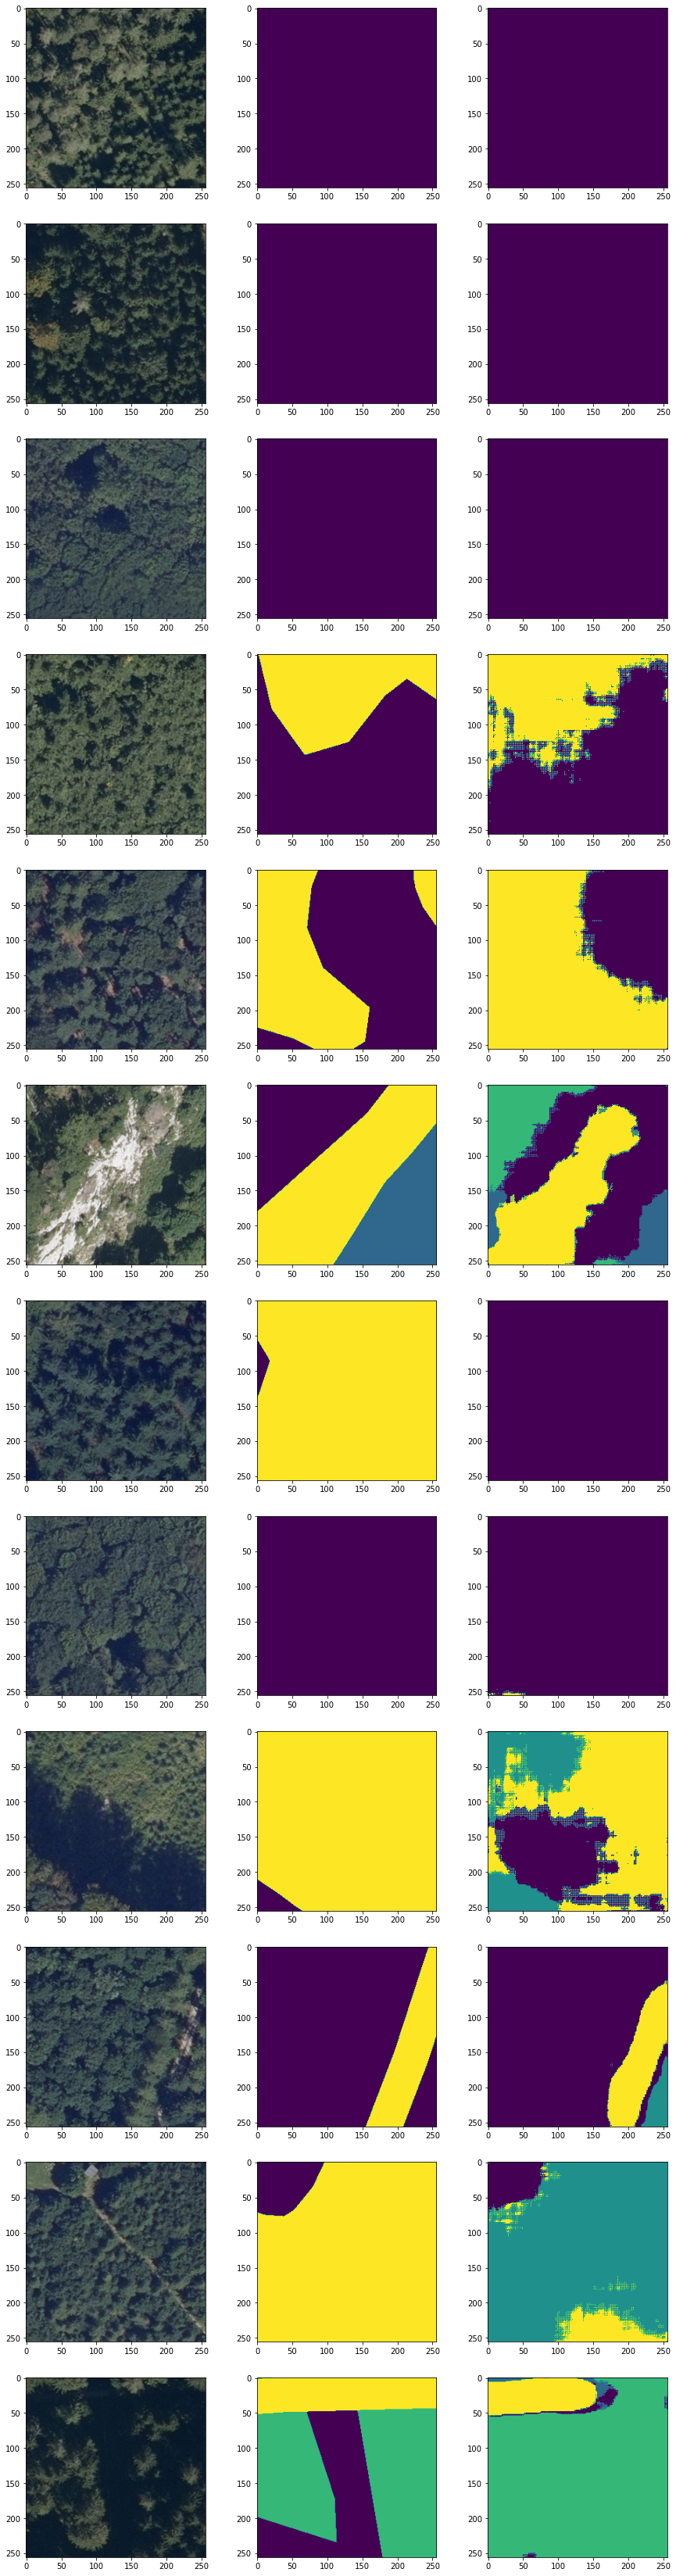

In [33]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [24]:
# save using pickle
#torch.save(unet,Path('model/unet_typ.pkl'))

# save 
torch.save(unet.state_dict(), SAVE_PATH)